# Cabify technical challenge

### Background
A ride hailing app currently assigns new incoming trips to the closest available vehicle. To compute such distance, the app currently computes haversine distance between the pickup point and each of the available vehicles. We refer to this distance as linear.

However, the expected time to reach A from B in a city is not 100% defined by Haversine distance: Cities are known to be places where huge amount of transport infrastructure (roads, highways, bridges, tunnels) is deployed to increase capacity and reduce average travel time. Interestingly, this heavy investment in infrastructure also implies that bird distance does not work so well as proxy, so the isochrones for travel time from certain location drastically differ from the perfect circle defined by bird distance, as we can see in this example from CDMX where the blue area represents that it is reachable within a 10 min drive.

In addition to this, travel times can be drastically affected by traffic, accidents, road work...So that even if a driver is only 300m away, he might need to drive for 10 min because of road work in a bridge.

### Proposal
In order to optimise operations, engineering team has suggested they could query an external real time maps API that not only has roads, but also knows realtime traffic information. We refer to this distance as road distance.

In principle this assigment is more efficient and should outperform linear. However, the queries to the maps API have a certain cost (per query) and increase the complexity and reliability of a critical system within the company. So Data Science team has designed an experiment to help engineering to decide

Experimental design
The designed expirement is very simple. For a period of 5 days, all trips in 3 cities (Bravos, Pentos and Volantis) have been randomly assigned using linear or road distance:

* Trips whose trip_id starts with digits 0-8 were assigned using road distance
* Trips whose trip_id starts with digits 9-f were assigned using linear distance

### Data description

The collected data is available available in this link. Each object represent a vehicle_interval that contains the following attributes:

type: can be going_to_pickup, waiting_for_rider or driving_to_destination
trip_id: uniquely identifies the trip
duration: how long the interval last, in seconds
distance: how far the vehicle moved in this interval, in meters
city_id: either bravos, pentos and volantis
started_at: when the interval started, UTC Time
vehicle_id: uniquely identifies the vehicle
rider_id: uniquely identifies the rider

Example
```
{
  "duration": 857,
  "distance": 5384,
  "started_at": 1475499600.287,
  "trip_id": "c00cee6963e0dc66e50e271239426914",
  "vehicle_id": "52d38cf1a3240d5cbdcf730f2d9a47d6",
  "city_id": "pentos",
  "type": "driving_to_destination"
}
```
Challenge
Try to answer the following questions

1. Should the company move towards road distance? What's the max price it would make sense to pay per query? (make all the assumptions you need, and make them explicit)
2. How would you improve the experimental design? Would you collect any additional data?

--------

Data can be downloaded from [here](https://www.dropbox.com/s/e3j1pybfz5o3vq9/intervals_challenge.json.gz?dl=0).

## Exploratory analysis

In [1]:
import scipy
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [2]:
df = pd.read_json("/home/andodet/code/notebooks/cabify/intervals_challenge.json", lines=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165170 entries, 0 to 165169
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   duration    165170 non-null  object        
 1   distance    165170 non-null  object        
 2   started_at  165170 non-null  datetime64[ns]
 3   trip_id     165170 non-null  object        
 4   vehicle_id  165170 non-null  object        
 5   city_id     165170 non-null  object        
 6   type        165170 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 8.8+ MB


In [4]:
df

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup
...,...,...,...,...,...,...,...
165165,NA,NA,2016-10-04 20:36:10.846999884,d2f81b419daddb90bd701ab9870f47a3,05e4532a59b7bfe65894335d1bc83e4d,volantis,driving_to_destination
165166,NA,NA,2016-10-04 20:36:12.719000101,73a07d4504036997306e0e3330529294,bed6dd187f23b3e8d956bb0d1ab0524a,volantis,waiting_for_rider
165167,NA,NA,2016-10-04 20:36:14.763000011,d98c047d565bd488b17e08594965c479,31cd2f19d27c0c0c0ca386de72866a81,bravos,driving_to_destination
165168,NA,NA,2016-10-04 20:36:15.957999945,ce9a7ae5f76667c9f92b149a1b345a2d,4a555013634506246eed5d801ffbe526,volantis,driving_to_destination


"NA" (str) is used for `nan` values. Let's reflect that.

In [5]:
# Replace "NA" strings with nan
df = df.replace("NA", np.nan, regex=True)

In [7]:
# Count nan values
df.isna().sum()

duration      1157
distance      1157
started_at       0
trip_id          0
vehicle_id       0
city_id          0
type             0
dtype: int64

In [8]:
# Out of 165170 rows, we can live without 1157 trips
df = df.dropna()

Trips seems to be of three types:

* `driving to destination`
* `going to pickup`
* `waiting for rider`

In [9]:
df.groupby("type")["trip_id"].nunique()

type
driving_to_destination    52098
going_to_pickup           58170
waiting_for_rider         53702
Name: trip_id, dtype: int64

We need to observe trip speed, hence we're not going to take `waiting for rider` status into account as it is not relevant for the task.

In [10]:
df = df[df["type"] != "waiting_for_rider"]

In [12]:
# Inspect date format
df["started_at"].head()

0   2016-10-03 13:00:00.286999941
1   2016-10-03 13:00:00.852999926
2   2016-10-03 13:00:01.670000076
3   2016-10-03 13:00:01.841000080
4   2016-10-03 13:00:01.970000029
Name: started_at, dtype: datetime64[ns]

In [13]:
# Reformat dates
df["started_at"] = pd.to_datetime(df.started_at)

# Get additional features
df["day"] = df["started_at"].dt.day
df["hour"] = df["started_at"].dt.hour
df["minute"] = df["started_at"].dt.minute

From the variables just created it's possible to bin them into categorical features to signal day/afternoon/night time rides.

In [14]:
# Bin by time of the day
df["night"] = np.where(df.hour < 8, 1, 0)
df["day"] = np.where((df.hour > 8) & (df.hour < 16),1, 0)
df["afternoon"] = np.where((df.hour > 16), 1, 0)

From challenge description, let's assign whether or not the trip used _road distance_ or _haversine distance_.

In [15]:
def get_metric(trip_id):
    """
    Encodes whether a trip was taken using haversine or road distance.
    From a trip_id, if first digit is 0-8 retunrs `linear`, `custom` otherwise.
    
    Arggs:
        trip_id (str): a trip id
        
    Returns:
        str: `linear` if distance is computed using haversine
            `custom` if distance is computed using road-distance API
    """
    
    first_char = trip_id[0]
    try:
        first_char = int(first_char)
        if first_char in range(0, 8):
            return("linear")
        else:
            return("custom")
    except:
        return("custom")
        
df["metric"] = df.apply(lambda x: get_metric(x.trip_id), axis=1)

In [16]:
df.groupby("metric")["trip_id"].count()

metric
custom    54765
linear    55544
Name: trip_id, dtype: int64

Let's get a sense of hourly distribution for rides.

If important, we could also check if the distribution changes in weekdays vs. weekend.

Text(0, 0.5, 'n. rides')

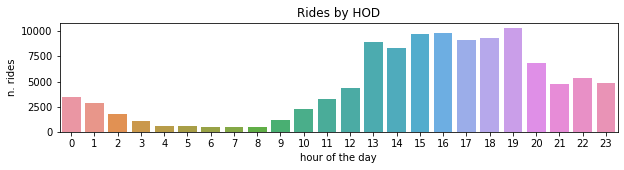

In [17]:
plt.figure(figsize=(10, 2))

data_plt = df.groupby("hour").agg({"trip_id": "count"}).reset_index()
sns.barplot(x="hour", y="trip_id", data=data_plt)

plt.title("Rides by HOD")
plt.xlabel("hour of the day")
plt.ylabel("n. rides")

## Data cleaning

### Distance

let's check for outliers in continuous variables.

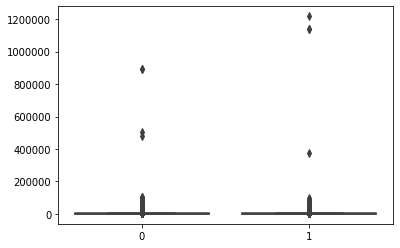

In [18]:
dist = [df[df['metric']=='custom'].distance,df[df['metric']!='custom'].distance]
sns.boxplot(data=dist)

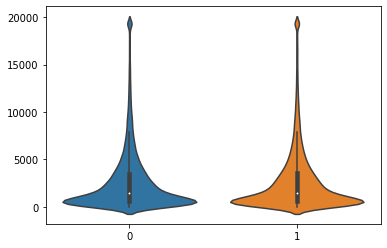

In [19]:
df["distance"] = st.mstats.winsorize(df.distance, limits = 0.01)  # Clipping extreme values

# Plot again
dist = [df[df['metric']=='custom'].distance,df[df['metric'] != 'custom'].distance]
sns.violinplot(data=dist)

### Duration

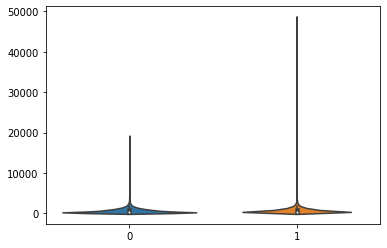

In [20]:
duration = [df[df['metric']=='custom'].duration,df[df['metric'] != 'custom'].duration]
sns.violinplot(data=duration)

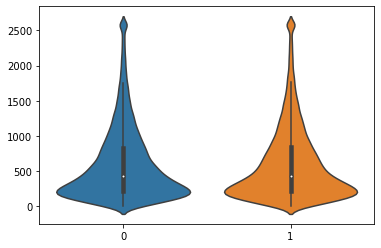

In [21]:
df["duration"] = st.mstats.winsorize(df.duration, limits = 0.01)

duration = [df[df['metric']=='custom'].duration,df[df['metric']!='custom'].duration]
sns.violinplot(data=duration)

### Speed

In [22]:
df["speed"] = df["distance"] / df["duration"]

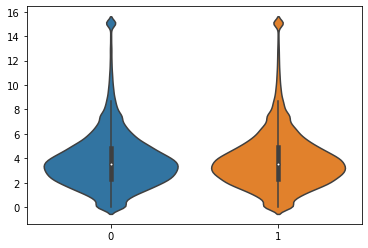

In [23]:
df["speed"] = st.mstats.winsorize(df.speed, limits=0.01)
speed = [df[df['metric']=='custom'].speed,df[df['metric'] != 'custom'].speed]
sns.violinplot(data=speed)

## Check distribution difference - t-test

From summary statistics, trip metrics seem to be the same between the two different apis.

In [24]:
df[df["metric"] == "custom"].describe()

,duration,distance,day,hour,minute,night,afternoon,speed
count,54765.000000,54765.000000,54765.000000,54765.000000,54765.000000,54765.000000,54765.000000,54765.000000
mean,597.166822,2676.068894,0.345166,15.126796,29.224979,0.101890,0.458906,3.868999
std,520.552687,3338.003525,0.475427,5.587488,17.370131,0.302506,0.498313,2.402074
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,578.000000,0.000000,13.000000,14.000000,0.000000,0.000000,2.339652
50%,432.000000,1465.000000,0.000000,16.000000,29.000000,0.000000,0.000000,3.514124
75%,832.000000,3486.000000,1.000000,19.000000,44.000000,0.000000,1.000000,4.874439
max,2583.000000,19335.000000,1.000000,23.000000,59.000000,1.000000,1.000000,15.083333


In [25]:
df[df["metric"] == "linear"].describe()

,duration,distance,day,hour,minute,night,afternoon,speed
count,55544.000000,55544.000000,55544.000000,55544.000000,55544.000000,55544.000000,55544.000000,55544.000000
mean,599.311087,2698.888503,0.345834,15.118879,29.182306,0.102783,0.457277,3.891875
std,523.569971,3361.819633,0.475644,5.603220,17.349417,0.303678,0.498176,2.419979
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,581.000000,0.000000,13.000000,14.000000,0.000000,0.000000,2.349597
50%,433.000000,1481.000000,0.000000,16.000000,29.000000,0.000000,0.000000,3.524687
75%,834.000000,3522.000000,1.000000,19.000000,44.000000,0.000000,1.000000,4.893245
max,2583.000000,19335.000000,1.000000,23.000000,59.000000,1.000000,1.000000,15.083333


We can perform a simple t-test to evaluate if the two distributions have no noticeable difference: if _p-value_ > 0.05 we can accept the _null_ hypothesis that the two 
distributions' means are the same.

In [28]:
# Let's get a sense of it
t2, p2 = st.ttest_ind(df[df["metric"] == "custom"].speed, df[df["metric"] != "custom"].speed)

print(f"t-test score: {t2}")
print(f"p-value: {p2}")

t-test score: -1.5755181926011994
p-value: 0.11513975033156397


The approach highlighted above concludes that there's no statistical significance across the two groups (assuming a confidence interval = 0.095).
Trusting this conclusion would lead to advice the product team **not** to implement any new API as it doesn't add any performance improvement over 
the current situation.

## Double check with CatBoost

### Trying to predict travel time 

Even if we're almost sure there is no difference between the two groups, for the sake of completeness, we will confirm this with an _indirect_ approach.
By establishing that the type of API used has no effect on predicting trip **duration** or **speed**.  

In [29]:
df.columns

Index(['duration', 'distance', 'started_at', 'trip_id', 'vehicle_id',
       'city_id', 'type', 'day', 'hour', 'minute', 'night', 'afternoon',
       'metric', 'speed'],
      dtype='object')

In [39]:
from sklearn.preprocessing import OneHotEncoder

# One hot encode only some features
df_final = pd.get_dummies(df, columns=["city_id", "type", "metric"])

In [40]:
df_final.head()

,duration,distance,started_at,trip_id,vehicle_id,day,hour,minute,night,afternoon,speed,city_id_bravos,city_id_pentos,city_id_volantis,type_driving_to_destination,type_going_to_pickup,metric_custom,metric_linear
0,857.0,5384.0,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,1,13,0,0,0,6.282380,0,1,0,1,0,1,0
1,245.0,1248.0,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,1,13,0,0,0,5.093878,0,0,1,0,1,0,1
2,1249.0,5847.0,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,1,13,0,0,0,4.681345,0,1,0,1,0,0,1
3,471.0,2585.0,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,1,13,0,0,0,5.488323,1,0,0,0,1,1,0
4,182.0,743.0,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,1,13,0,0,0,4.082418,0,1,0,0,1,0,1


Now, we add a randomly assigned variable as a sanity-check for our model. The reasoning behind this is that all the features less important than the random variables
are completely useless to the model (less informative than random). If `metric` (whether or not the new API was used for distance calculation) falls behind `random` we can
safely affirm that it has no effect whatsoever in predicting `distacnce`.

In [57]:
# Randomly assign a variable
df_final["random"] = np.random.random(size=[df_final.shape[0],1])

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor

x_train, x_test, y_train, y_test = train_test_split(df_final.drop(columns=["duration", "distance", "speed"])._get_numeric_data(),
                                                    df["speed"])

In [59]:
cb = CatBoostRegressor(iterations=300, verbose=50)
cb.fit(x_train, y_train)

Learning rate set to 0.213862
0:	learn: 2.3120662	total: 8.54ms	remaining: 2.55s
50:	learn: 2.1046451	total: 318ms	remaining: 1.55s
100:	learn: 2.0906800	total: 652ms	remaining: 1.28s
150:	learn: 2.0792630	total: 931ms	remaining: 919ms
200:	learn: 2.0691019	total: 1.2s	remaining: 589ms
250:	learn: 2.0605698	total: 1.46s	remaining: 286ms
299:	learn: 2.0517902	total: 1.73s	remaining: 0us


In [61]:
cb.score(x_train, y_train)

0.27628510443506427

In [62]:
cb.score(x_test, y_test)

0.22739615883766795

The model has worse performance than randomly guessing whether or not a trip was taken using the new api. So far we're confirming that there's no
difference between the 2 apis.

In [63]:
def plot_feat_importance(cols, model_feats, cols_plotted=10, model_name="Catboost"):
    feat_importance = pd.Series(index=cols, data=np.abs(model_feats))
    n_selected_features = (feat_importance > 0).sum()
    plt.figure()
    feat_importance.sort_values().tail(cols_plotted).plot(kind="bar", figsize=(10,2))
    plt.title("Feature importance for {}".format(model_name))
    plt.show()

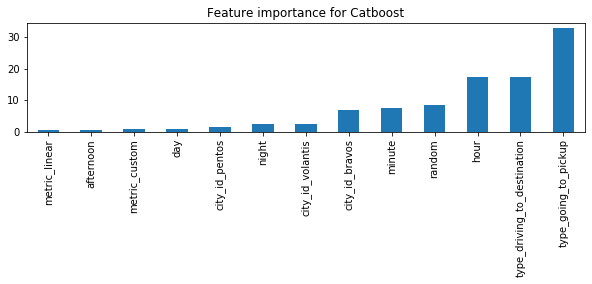

In [64]:
plot_feat_importance(cols=x_train.columns,
                     model_feats=cb.get_feature_importance(),
                     cols_plotted=15)

`metric_linear` and `metric_custom` are way down the list (less important than random). Hence it is safe to say that 
the new API has no effect on the trip duration or speed.

### Verify if `metric` is randomly assigned

Let's confirm that in our a/b test setting, `metric` was randomly assigned among observation and no selection bias is present in our
experimental setting.

In [68]:
cb = CatBoostClassifier(iterations=300, verbose=50)

In [69]:
df_final.columns

Index(['duration', 'distance', 'started_at', 'trip_id', 'vehicle_id', 'day',
       'hour', 'minute', 'night', 'afternoon', 'speed', 'city_id_bravos',
       'city_id_pentos', 'city_id_volantis', 'type_driving_to_destination',
       'type_going_to_pickup', 'metric_custom', 'metric_linear', 'random'],
      dtype='object')

In [70]:
x_train, x_test, y_train, y_test = train_test_split(df_final.drop(columns=["metric_linear", "metric_custom"])._get_numeric_data(),
                                                    df_final.metric_custom)

In [71]:
cb.fit(x_train, y_train)

Learning rate set to 0.204766
0:	learn: 0.6929505	total: 47.1ms	remaining: 14.1s
50:	learn: 0.6871611	total: 622ms	remaining: 3.04s
100:	learn: 0.6812140	total: 1.18s	remaining: 2.32s
150:	learn: 0.6754191	total: 1.72s	remaining: 1.7s
200:	learn: 0.6698845	total: 2.28s	remaining: 1.12s
250:	learn: 0.6648546	total: 2.83s	remaining: 552ms
299:	learn: 0.6602091	total: 3.39s	remaining: 0us


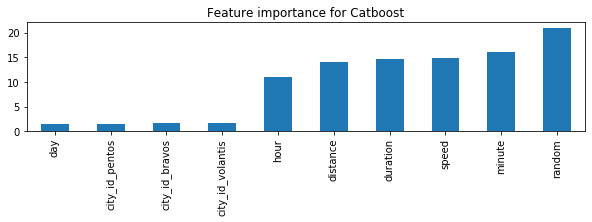

In [72]:
plot_feat_importance(x_train.columns,
                        cb.get_feature_importance(), 10)

In [92]:
from operator import itemgetter

sorted(list(zip(cb.feature_names_, cb.get_feature_importance())), key=itemgetter(1), reverse=True)

[('random', 20.988360535381666),
 ('minute', 16.107026527136746),
 ('speed', 14.741576870895713),
 ('duration', 14.610947577431492),
 ('distance', 14.03678404190466),
 ('hour', 11.021529904699296),
 ('city_id_volantis', 1.6347248800994616),
 ('city_id_bravos', 1.6183810910595462),
 ('city_id_pentos', 1.49063539939274),
 ('day', 1.454926029863818),
 ('type_driving_to_destination', 0.7316748262308683),
 ('type_going_to_pickup', 0.7174303603234413),
 ('night', 0.5369729582683501),
 ('afternoon', 0.30902899731222)]

Experimental setting is solid as the observations seems to be randomly assigned between the two groups (no bias artificially injected in the test). Once more,
we can safely state that it wouldn't make sense to invest on implementing the road-distance API.